In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import einsum
import torch.autograd as autograd
import torch.distributions as D
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("..")

from src.gof.gof import KSD, GoodnessOfFitTest, PKSD, MaxSKSD
from src.Sliced_KSD_Clean.Divergence.Kernel import *
from src.kernel import RBF
from pymanopt.manifolds import Grassmann

In [14]:
nsample = 100
nbootstrap = 100
torch.manual_seed(1)

In [15]:
mean = torch.Tensor([0])
var = torch.Tensor([1])

# null distribution
null_p = D.Normal(mean, var)

# sample from true distribution
x = 0.5 + torch.randn((nsample, 1)).requires_grad_(True)

In [16]:
k = RBF(sigma=1, method=None)

ksd = KSD(log_prob=null_p.log_prob, kernel=k)
gof_ksd = GoodnessOfFitTest(ksd, x)

In [17]:
gof_ksd.compute_pvalue(nbootstrap)

(array([-1.22463974e-02,  1.40658120e-02, -9.38007482e-03, -1.18258735e-02,
        -6.97836798e-03, -1.55270476e-02,  7.27735555e-02,  1.03359180e-02,
         3.27520739e-02, -9.75650753e-03,  1.63682031e-02, -1.24607794e-03,
         2.49795245e-02, -8.94298010e-03,  4.39490842e-03, -5.97405415e-03,
         1.94088705e-03,  1.48007120e-02,  3.61465892e-03, -8.19843114e-03,
        -1.12803570e-02, -5.70533073e-03, -2.28996383e-03, -6.33875553e-03,
         7.11293364e-03, -1.09034017e-02,  1.06264921e-02, -1.19030614e-02,
         1.02044408e-02, -9.45051192e-03,  3.88349839e-03,  2.12893265e-02,
        -1.10236075e-02, -8.83744323e-03,  4.80980403e-03, -1.17865228e-02,
        -1.34892172e-02,  3.41319697e-03, -1.60039953e-02, -9.14086176e-03,
         9.55438901e-03,  1.15429903e-02,  1.84300801e-02, -5.55852494e-03,
        -2.00960059e-03,  4.43359747e-03,  3.26902344e-02,  5.08614689e-03,
        -2.59676418e-03, -4.71765631e-03, -1.35868585e-02,  5.21333470e-03,
         5.7

# Projected KSD

In [18]:
nsample = 3
nbootstrap = 100
torch.manual_seed(1)

In [19]:
mean = torch.Tensor([0])
var = torch.Tensor([1])

# null distribution
p_null = D.Normal(mean, var)

# sample from true distribution
x = 0.5 + torch.randn((nsample, 1)).requires_grad_(True)
P = torch.Tensor([[1]])

In [20]:
k = RBF(sigma=1, method=None)
manifold = Grassmann(x.shape[1], 1)
    
pksd = PKSD(log_prob=p_null.log_prob, kernel=k, manifold=manifold, P=P)
gof_pksd = GoodnessOfFitTest(pksd, x)

In [21]:
gof_pksd.compute_pvalue(nbootstrap)

(array([-0.17322897, -0.29298804, -0.17322897,  0.        , -0.29298804,
        -0.32473629, -0.32473629, -0.60769771, -0.17322897, -0.32473629,
        -0.29298804, -1.06221969, -0.29298804, -0.29298804,  0.        ,
        -0.29298804, -0.17322897, -0.32473629, -0.32473629, -0.29298804,
        -0.60769771,  0.        , -0.29298804, -0.17322897,  0.        ,
        -0.17322897, -0.29298804, -0.32473629,  0.        ,  0.        ,
        -0.32473629, -0.29298804, -0.29298804,  0.        , -0.17322897,
        -0.17322897, -0.17322897, -0.29298804, -0.32473629, -0.29298804,
        -0.17322897, -0.32473629,  0.        , -0.29298804, -0.32473629,
        -1.06221969, -0.32473629, -0.32473629, -0.17322897, -0.32473629,
         0.        ,  0.        ,  0.        , -0.29298804,  0.        ,
        -0.17322897, -0.17322897, -0.29298804,  0.        ,  0.        ,
        -0.29298804, -0.17322897, -0.32473629, -0.32473629,  0.        ,
        -0.17322897, -0.70294248,  0.        , -0.3

# 1. $p=q$

$p = \mathcal{N}(0, I_d)$

In [2]:
from tqdm.notebook import tqdm

In [4]:
# torch.manual_seed(1)

nsample = 100
nbootstrap = 1000
nrepeat = 100
prop_train = 0.2
sig_level = 0.05

dims = np.concatenate((np.array([1, 2, 5]), np.arange(10, 110, 10)))
dims = np.concatenate((np.array([2, 5]), np.arange(10, 110, 10)))
# dims = np.array([1, 2, 5])

In [6]:
ksd_stats = [0] * len(dims)
ksd_pvals = [0] * len(dims)
ksd_rejrates = [0] * len(dims)
# res = pd.DataFrame(0, columns=["ksd", "pksd"])

pksd_pvals = [0] * len(dims)
pksd_rejrates = [0] * len(dims)

maxSKSD_pvals = [0] * len(dims)
maxSKSD_rejrates = [0] * len(dims)

ntrain = int(nsample*prop_train)
for i, dim in enumerate(dims):
    print(f"Running for dim = {dim}")
    ksd_stat = [0] * nrepeat
    ksd_pval = [0] * nrepeat
    pksd_stat = [0] * nrepeat
    pksd_pval = [0] * nrepeat
    maxSKSD_stat = [0] * nrepeat
    maxSKSD_pval = [0] * nrepeat   
    # alternative distribution
    mean = torch.zeros(dim)
    var = torch.diag(torch.ones(dim))
    p_null = D.MultivariateNormal(mean, var)

    # sample from null distribution
    p_alt = D.MultivariateNormal(mean, var)
    
    P = torch.ones((dim, dim))[:2 :]
    
    k = RBF(sigma=1, method=None)
    manifold = Grassmann(dim, min(2, dim))
    
    print("Begin Repeat")
    for j in tqdm(range(nrepeat)):
        x_ksd = p_alt.sample((nsample, )).requires_grad_(True)
        x_pksd = x_ksd.clone().requires_grad_(True)
        xtrain, xtest = x_pksd[:ntrain, :], x_pksd[ntrain:, :]
        
        ## ksd
        ksd = KSD(log_prob=p_null.log_prob, kernel=k)
        gof_ksd = GoodnessOfFitTest(ksd, x_ksd)
        ksd_boots_val, ksd_stat_val, ksd_pval_val = gof_ksd.compute_pvalue(nbootstrap)
        
        ksd_stat[j] = ksd_stat_val
        ksd_pval[j] = ksd_pval_val
        
        ## pksd
        pksd = PKSD(log_prob=p_null.log_prob, kernel=k, manifold=manifold, P=P)
        _, _ = pksd.train_projection(xtrain, xtrain, epochs=100, delta=1e-4)
        gof_pksd = GoodnessOfFitTest(pksd, xtest)
        pksd_boots_val, pksd_stat_val, pksd_pval_val = gof_pksd.compute_pvalue(nbootstrap)
        
        pksd_stat[j] = pksd_stat_val
        pksd_pval[j] = pksd_pval_val
        
        ## maxSKSD
        g = torch.eye(xtrain.shape[-1]).requires_grad_()
        r = torch.eye(xtrain.shape[-1])
        optimizer = torch.optim.Adam([g], lr=1e-2, betas=(0.5, 0.9))
        maxSKSD = MaxSKSD(
            log_prob=p_null.log_prob,
            kernel=SE_kernel,
            d_kernel=d_SE_kernel,
            dd_kernel=dd_SE_kernel,
            optimizer=optimizer,
            r=r,
            g=g
        )
        maxSKSD.train_projection(xtrain, xtrain, g=g, epochs=100)
        gof_maxSKSD = GoodnessOfFitTest(maxSKSD, xtest)
        maxSKSD_boots_val, maxSKSD_stat_val, maxSKSD_pval_val = gof_maxSKSD.compute_pvalue(nbootstrap)
        
        maxSKSD_stat[j] = maxSKSD_boots_val
        maxSKSD_pval[j] = maxSKSD_stat_val
        
    ksd_stats[i] = ksd_stat
    ksd_pvals[i] = ksd_pval
    ksd_rejrates[i] = np.mean(np.array(ksd_pval) < sig_level)
    
    pksd_pvals[i] = pksd_pval
    pksd_rejrates[i] = np.mean(np.array(pksd_pval) < sig_level)
    
    maxSKSD_pvals[i] = maxSKSD_pval
    maxSKSD_rejrates[i] = np.mean(np.array(maxSKSD_pval) < sig_level)

Running for dim = 2
Begin Repeat


  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (2) must match the size of tensor b (80) at non-singleton dimension 2

In [ ]:
gof_ksd.d(x_ksd, x_ksd)

In [67]:
gof_ksd.d(x_ksd, x_ksd) - np.diag(np.diag(gof_ksd.d(x_ksd, x_ksd)))

array([[ 0.0000000e+00, -2.7249650e-41, -4.3300123e-43, ...,
        -5.4484654e-38, -2.6267536e-39, -7.3994469e-37],
       [-2.7249650e-41,  0.0000000e+00,  0.0000000e+00, ...,
        -1.6279747e-36,  0.0000000e+00, -7.1990447e-40],
       [-4.3300123e-43,  0.0000000e+00,  0.0000000e+00, ...,
        -4.9493862e-42,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-5.4484659e-38, -1.6279747e-36, -4.9493862e-42, ...,
         0.0000000e+00, -3.8309762e-38,  0.0000000e+00],
       [-2.6267536e-39,  0.0000000e+00,  0.0000000e+00, ...,
        -3.8309762e-38,  0.0000000e+00, -5.4576792e-40],
       [-7.3994469e-37, -7.1990447e-40,  0.0000000e+00, ...,
         0.0000000e+00, -5.4576792e-40,  0.0000000e+00]], dtype=float32)

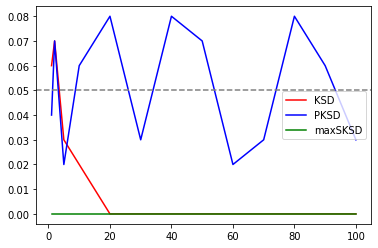

In [69]:
plt.plot(dims, ksd_rejrates, color="r", label="KSD")
plt.plot(dims, pksd_rejrates, color="b", label="PKSD")
plt.plot(dims, maxSKSD_rejrates, color="g", label="maxSKSD")

plt.axhline(sig_level, color="grey", linestyle="--")
plt.legend()

In [59]:
# from src.Sliced_KSD_Clean.Divergence.Kernel import *
# g = torch.eye(xtrain.shape[-1]).requires_grad_()
# print(g)
# r = torch.eye(xtrain.shape[-1])
# optimizer = torch.optim.Adam([g], lr=1e-2, betas=(0.5, 0.9))
# maxSKSD = MaxSKSD(
#     log_prob=null_p.log_prob,
#     kernel=SE_kernel,
#     d_kernel=d_SE_kernel,
#     dd_kernel=dd_SE_kernel,
#     optimizer=optimizer,
#     r=r,
#     g=g
# )
# maxSKSD.train_projection(xtrain, xtrain, g=g, epochs=3000)
# gof_maxSKSD = GoodnessOfFitTest(maxSKSD, x)
# print(maxSKSD.g)

# Multivariate Gaussian with effective dims

In [49]:
def gaussian_experiment(dims, nsample, nbootstrap, nrepeat, sig_level=0.05, prop_train=0.2):
    
    ksd_stats = [0] * len(dims)
    ksd_pvals = [0] * len(dims)
    ksd_rejrates = [0] * len(dims)

    pksd_pvals = [0] * len(dims)
    pksd_rejrates = [0] * len(dims)

    ntrain = int(nsample*prop_train)
    for i, dim in enumerate(dims):
        print(f"Running for dim = {dim}")
        ksd_stat = [0] * nrepeat
        ksd_pval = [0] * nrepeat
        pksd_stat = [0] * nrepeat
        pksd_pval = [0] * nrepeat

        # alternative distribution
        mean = torch.zeros(dim)
        cov = torch.diag(torch.ones(dim))
        p_alt = D.MultivariateNormal(mean, cov)

        # null distribution
        mean_null = torch.zeros(dim)
        mean_null[:2] = 1
        cov_null = torch.eye(dim)
        p_null = D.MultivariateNormal(mean_null, cov_null)

        P = torch.ones((dim, dim))[:2 :]

        k = RBF(sigma=1, method=None)
        manifold = Grassmann(dim, min(2, dim))

        for j in tqdm(range(nrepeat)):
            x_ksd = p_alt.sample((nsample, )).requires_grad_(True)
            x_pksd = x_ksd.clone().requires_grad_(True)
            xtrain, xtest = x_pksd[:ntrain, :], x_pksd[ntrain:, :]

            ## ksd
            ksd = KSD(log_prob=p_null.log_prob, kernel=k)
            gof_ksd = GoodnessOfFitTest(ksd, x_ksd)
            ksd_boots_val, ksd_stat_val, ksd_pval_val = gof_ksd.compute_pvalue(nbootstrap)

            ksd_stat[j] = ksd_stat_val
            ksd_pval[j] = ksd_pval_val

            ## pksd
            pksd = PKSD(log_prob=p_null.log_prob, kernel=k, manifold=manifold, P=P)
            _, _ = pksd.train_projection(xtrain, xtrain, epochs=100, delta=1e-4)
            gof_pksd = GoodnessOfFitTest(pksd, xtest)
            pksd_boots_val, pksd_stat_val, pksd_pval_val = gof_pksd.compute_pvalue(nbootstrap)

            pksd_stat[j] = pksd_stat_val
            pksd_pval[j] = pksd_pval_val

        ksd_stats[i] = ksd_stat
        ksd_pvals[i] = ksd_pval
        ksd_rejrates[i] = np.mean(np.array(ksd_pval) < sig_level)

        pksd_pvals[i] = pksd_pval
        pksd_rejrates[i] = np.mean(np.array(pksd_pval) < sig_level)
    return(ksd_rejrates, pksd_rejrates)

In [50]:
dims = [50]
nsample = 100
nbootstrap = 1000
nrepeat = 100
sig_level = 0.05

In [51]:
ksd_rejrates, pksd_rejrates = gaussian_experiment(
    dims=dims, 
    nsample=nsample, 
    nbootstrap=nbootstrap, 
    nrepeat=nrepeat, 
    sig_level=sig_level
)

Running for dim = 50


  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
print(ksd_rejrates)
print(pksd_rejrates)

[0.0]
[1.0]


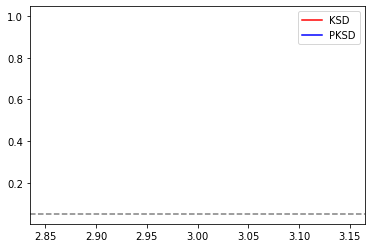

In [12]:
plt.plot(dims, ksd_rejrates, color="r", label="KSD")
plt.plot(dims, pksd_rejrates, color="b", label="PKSD")
plt.axhline(sig_level, color="grey", linestyle="--")
plt.legend()

# Train projection

In [35]:
dim = 50
nsample = 100
nbootstrap = 1000
nrepeat = 100
sig_level = 0.05

# dims = np.concatenate((np.array([1, 2, 5]), np.arange(10, 110, 10)))
# dims = np.array([1, 2, 5])

# alternative distribution
mean = torch.zeros(dim)
cov = torch.diag(torch.ones(dim))
p_alt = D.MultivariateNormal(mean, cov)

# null distribution
mean_null = torch.zeros(dim)
mean_null[:2] = 1
cov_null = torch.eye(dim)
p_null = D.MultivariateNormal(mean_null, cov_null)

P = torch.ones((dim, dim))[:2 :]

k = RBF(sigma=1, method=None)
manifold = Grassmann(dim, dim)

# ksd = KSD(log_prob=p_null.log_prob, kernel=k)
pksd = PKSD(log_prob=p_null.log_prob, kernel=k, manifold=manifold, P=P)

In [41]:
x = p_alt.sample((nsample, )).requires_grad_(True)

In [42]:
# gof_ksd = GoodnessOfFitTest(ksd, x.detach().requires_grad_(True))
# ksd_boots_val, ksd_stat_val, ksd_pval_val = gof_ksd.compute_pvalue(nbootstrap)

In [43]:
train_prop = 0.2
x_train = x[:int(x.shape[0]*train_prop), :].detach().requires_grad_(True)
x_test = x[int(x.shape[0]*train_prop):, :].detach().requires_grad_(True)
P_ls, stats_ls = pksd.train_projection(x_train, x_train, epochs=100, delta=1e-4)

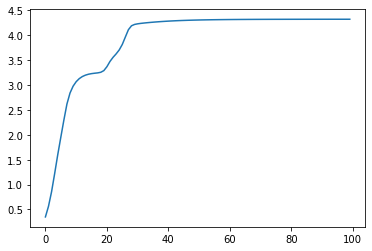

In [44]:
plt.plot(stats_ls)

In [45]:
P_ls[-1], pksd.P, P_ls[0]

(array([[-0.46304756, -0.57275194, -0.01805321,  0.05897039,  0.04819657,
         -0.10065053, -0.01382178,  0.00736601, -0.08258627, -0.01600119,
          0.0449691 , -0.01637276,  0.0384306 ,  0.02693243, -0.12201211,
         -0.04107516, -0.05050454,  0.00213393,  0.04420745,  0.05518517,
          0.04319487,  0.05801848,  0.12792744,  0.2080862 ,  0.02781599,
         -0.11553015, -0.08381223,  0.08712358,  0.13308868, -0.09906239,
         -0.05153497, -0.0803784 , -0.08215466,  0.14681432,  0.09926663,
         -0.04104757, -0.06493483, -0.03420531, -0.08536061, -0.07375199,
         -0.12918225, -0.05004876, -0.07832478, -0.07638361,  0.10772901,
          0.01919129,  0.14324698, -0.36058983, -0.14884886,  0.03569964],
        [ 0.14407161,  0.16501415,  0.03564508,  0.25578088, -0.23808798,
         -0.21634099, -0.10329926, -0.11094272, -0.07031459, -0.33057484,
          0.05459561,  0.08022474,  0.13465855,  0.20502894,  0.07307053,
         -0.22186047, -0.02693989, -0

In [46]:
gof_pksd = GoodnessOfFitTest(pksd, x_test.detach().requires_grad_(True))
pksd_boots_val, pksd_stat_val, pksd_pval_val = gof_pksd.compute_pvalue(nbootstrap)

pksd.P = torch.Tensor(P_ls[0])
gof_pksd2 = GoodnessOfFitTest(pksd, x.detach().requires_grad_(True))
pksd_boots_val2, pksd_stat_val2, pksd_pval_val2 = gof_pksd.compute_pvalue(nbootstrap)

In [48]:
# print(ksd_stat_val, pksd_stat_val, pksd_stat_val2)
# print(ksd_pval_val, pksd_pval_val, pksd_pval_val2)
print(pksd_stat_val, pksd_stat_val2)
print(pksd_pval_val, pksd_pval_val2)

0.48601815911787977 0.22317050982125197
0.0 0.0


In [86]:
lap = D.laplace.Laplace(torch.Tensor([0,0,0]), torch.Tensor([1/np.sqrt(2), 1/np.sqrt(2), 1/np.sqrt(2)]))
lap_1d = D.laplace.Laplace(torch.Tensor([0]), torch.Tensor([1/np.sqrt(2)]))